In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

dv001.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/IPMI-2023


In [3]:
import sys, os
import numpy as np
import pandas as pd

sys.path.append('..')
%aimport mre_pinn

sys.path.append('../../param_search')
%aimport param_search
ps = param_search

Using backend: pytorch



# IPMI 2023 FEM box experiment

In [4]:
%pwd

'/ocean/projects/asc170022p/mtragoza/mre-pinn/IPMI-2023'

In [5]:
# define the job template and name format

template = '''\
#!/bin/bash
#SBATCH --job-name={job_name}
#SBATCH --account=asc170022p
#SBATCH --partition=GPU-shared
#SBATCH --gres=gpu:1
#SBATCH --time=48:00:00
#SBATCH -o %J.stdout
#SBATCH -e %J.stderr
#SBATCH --mail-type=all

hostname
pwd
source activate MRE-PINN

python ../../../train.py \\
    --xarray_dir {xarray_dir} \\
    --example_id {example_id} \\
    --frequency {frequency} \\
    --omega {omega} \\
    --polar_input {polar_input} \\
    --pde_name {pde_name} \\
    --pde_warmup_iters 10000 \\
    --pde_step_iters 5000 \\
    --pde_step_factor 10 \\
    --pde_init_weight {pde_init_weight} \\
    --pde_loss_weight {pde_loss_weight} \\
    --save_prefix {job_name}    
'''
name = 'train_{data_name}_{example_id}_{pde_name}'

# define the parameter space

fem_box_space = ps.ParamSpace(
    data_name='fem_box',
    xarray_dir='../../../data/BIOQIC/fem_box',
    example_id=[50, 60, 70, 80, 90, 100],
    frequency='auto',
    omega=30,
    pde_name=['helmholtz', 'hetero'],
    pde_init_weight=1e-10,
    pde_loss_weight=1e-8,
    polar_input=0,
)
phantom_space = ps.ParamSpace(
    data_name='phantom',
    xarray_dir='../../../data/BIOQIC/phantom',
    example_id=[30, 40, 50, 60, 70, 80, 90, 100],
    frequency='auto',
    omega=30,
    pde_name=['hetero'],
    pde_init_weight=1e-12,
    pde_loss_weight=1e-10,
    polar_input=0,
)
patient_space = ps.ParamSpace(
    data_name='patient',
    xarray_dir='../../../data/NAFLD/v3',
    example_id=['0006', '0020', '0024', '0029', '0043', '0047', '0126', '0135', '0155', '0164', '0172', '0173', '0210', '0213', '0219', '0222', '0234', '0235', '0291', '0344', '0378', '0384', '0395', '0401', '0415', '0457', '0461', '0491', '0492', '0496', '0509', '0510', '0516', '0525', '0564', '0604', '0612', '0615', '0628', '0639', '0648', '0650', '0653', '0655', '0659', '0693', '0704', '0717', '0727', '0734', '0737', '0740', '0747', '0748', '0898', '0900', '0929', '0931', '0932', '0940', '0954', '0964', '0965', '0979', '0989', '0995', '1028', '1033', '1039', '1045', '1075', '1076', '1077', '1083', '1103', '1106', '1108', '1110', '1119', '1121', '1123', '1134', '1144', '1149', '1205', '1207', '1215', '1217', '1230', '1261', '1271', '1296', '1303', '1311', '1329', '1337', '1341', '1343', '1344', '1382', '1395', '1400', '1404', '1417', '1426', '1427', '1433', '1435', '1448', '1453', '1456', '1464', '1671', '1679', '1694', '1699', '1706', '1712', '1714', '1715', '1720', '1722', '1727', '1736', '1748', '1785', '1786', '1790', '1791', '1793', '1795', '1798', '1806', '1807', '1819', '1829', '1839', '1843', '1851', '1853', '1896', '1899', '1903', '1917', '1935', '1940', '1948', '1967', '1979', '1980', '2001', '2007', '2029', '2034', '2046'],
    frequency=40,
    omega=60,
    pde_name=['hetero'],
    pde_init_weight=1e-18,
    pde_loss_weight=1e-16,
    polar_input=1,
)

param_space = fem_box_space
len(param_space)

12

In [6]:
%autoreload
expt_name = '2022-11-23_fem_box_init'

#jobs = ps.submit(template, name, param_space, work_dir=expt_name, verbose=True)
#jobs.to_csv(f'{expt_name}.jobs')

jobs = pd.read_csv(f'{expt_name}.jobs')

In [7]:
status_cols = ['job_name', 'job_state', 'node_id', 'runtime', 'stdout', 'stderr']
status = ps.status(jobs)[status_cols]
status

,job_name,job_state,node_id,runtime,stdout,stderr
job_id,,,,,,
13256772,train_fem_box_50_helmholtz,NaN,NaN,NaN,v020.ib.bridges2.psc.edu\n/ocean/projects/asc1...,Using backend: pytorch\n\n
13256773,train_fem_box_50_hetero,NaN,NaN,NaN,v020.ib.bridges2.psc.edu\n/ocean/projects/asc1...,Using backend: pytorch\n\n
13256774,train_fem_box_60_helmholtz,NaN,NaN,NaN,v024.ib.bridges2.psc.edu\n/ocean/projects/asc1...,Using backend: pytorch\n\n
13256775,train_fem_box_60_hetero,NaN,NaN,NaN,v016.ib.bridges2.psc.edu\n/ocean/projects/asc1...,Using backend: pytorch\n\n
13256776,train_fem_box_70_helmholtz,NaN,NaN,NaN,v017.ib.bridges2.psc.edu\n/ocean/projects/asc1...,Using backend: pytorch\n\n
13256777,train_fem_box_70_hetero,NaN,NaN,NaN,v017.ib.bridges2.psc.edu\n/ocean/projects/asc1...,Using backend: pytorch\n\n
13256778,train_fem_box_80_helmholtz,NaN,NaN,NaN,v025.ib.bridges2.psc.edu\n/ocean/projects/asc1...,Using backend: pytorch\n\n
13256779,train_fem_box_80_hetero,NaN,NaN,NaN,v025.ib.bridges2.psc.edu\n/ocean/projects/asc1...,Using backend: pytorch\n\n
13256780,train_fem_box_90_helmholtz,NaN,NaN,NaN,v025.ib.bridges2.psc.edu\n/ocean/projects/asc1...,Using backend: pytorch\n\n


In [8]:
print(status.iloc[0].stdout[-100:])

                         5                    NaN  ...  10004.933585

[29088 rows x 3 columns]
Done



In [9]:
metrics = ps.metrics(jobs)

# did all models train to 25k iterations?
assert (metrics.groupby('job_name')['iteration'].max() == 100e3).all()

# get the final test evaluations
metrics = metrics[metrics.iteration == 100e3]

param_cols = ['pde_name', 'example_id'] # experimental parameters
index_cols = ['variable_name', 'spatial_frequency_bin', 'spatial_region'] # metric identifiers
metric_cols = ['MSAV', 'PSD', 'MAV'] # metric values

metrics = metrics.groupby(param_cols + index_cols, sort=False)[metric_cols].mean()
metrics = metrics.unstack(level=[len(param_cols)])

def metric_map(t):
    metric_name, var_name = t
    new_col_name = f'{var_name}_{metric_name}'
    new_col_name = new_col_name.replace('diff_MSAV', 'pred_MSAE')
    new_col_name = new_col_name.replace('pde_diff_MSAV', 'PDE_MSAE')
    new_col_name = new_col_name.replace('diff_MAV', 'pred_MAD')
    return new_col_name

metrics.columns = [metric_map(t) for t in metrics.columns.to_flat_index()]
metrics

u_pred_MSAV  \
pde_name  example_id spatial_frequency_bin spatial_region                
helmholtz 50         all                   all                0.000106   
                                           1                       NaN   
                                           2                       NaN   
                                           3                       NaN   
                                           4                       NaN   
...                                                                ...   
hetero    100        6.0                   all                     NaN   
                     7.0                   all                     NaN   
                     8.0                   all                     NaN   
                     9.0                   all                     NaN   
                     10.0                  all                     NaN   

                                                            u_pred_MSAE  \
pde_name  example_id spatial_frequency_bin spatial_region                 
helmholtz 50         all                   all             9.598885e-09   
                                           1                        NaN   
                                           2                        NaN   
                                           3                        NaN   
                                           4                        NaN   
...                                                                 ...   
hetero    100        6.0                   all                      NaN   
                     7.0                   all                      NaN   
                     8.0                   all                      NaN   
                     9.0                   all                      NaN   
                     10.0                  all                      NaN   

                                                           u_true_MSAV  \
pde_name  example_id spatial_frequency_bin spatial_region                
helmholtz 50         all                   all                0.000107   
                                           1                       NaN   
                                           2                       NaN   
                                           3                       NaN   
                                           4                       NaN   
...                                                                ...   
hetero    100        6.0                   all                     NaN   
                     7.0                   all                     NaN   
                     8.0                   all                     NaN   
                     9.0                   all                     NaN   
                     10.0                  all                     NaN   

                                                            lu_pred_MSAV  \
pde_name  example_id spatial_frequency_bin spatial_region                  
helmholtz 50         all                   all             112807.467742   
                                           1                         NaN   
                                           2                         NaN   
                                           3                         NaN   
                                           4                         NaN   
...                                                                  ...   
hetero    100        6.0                   all                       NaN   
                     7.0                   all                       NaN   
                     8.0                   all                       NaN   
                     9.0                   all                       NaN   
                     10.0                  all                       NaN   

                                                           lu_pred_MSAE  \
pde_name  example_id spatial_frequency_bin spatial_region                 
helmholtz 50      

<IPython.core.display.Javascript object>


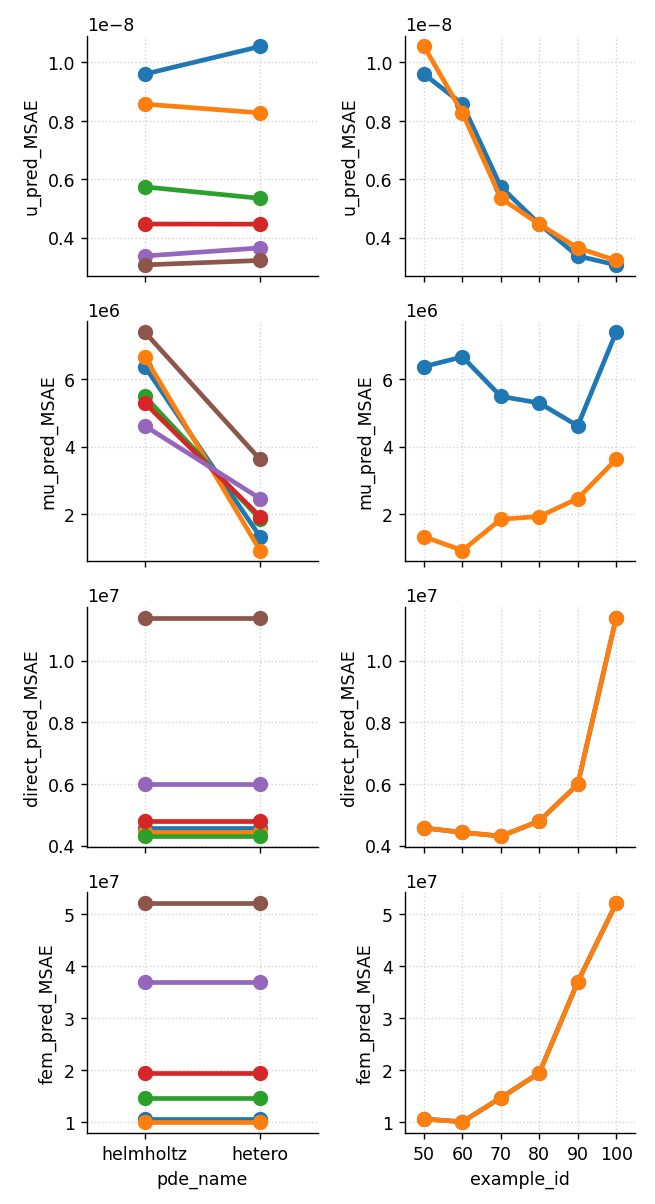

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.a

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.a

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))



In [14]:
m = metrics.reset_index()

fig = ps.plot(
    m[m.spatial_region == 'all'],
    x=param_cols,
    y=['u_pred_MSAE', 'mu_pred_MSAE', 'direct_pred_MSAE', 'fem_pred_MSAE'],
    height=2.5,
    width=2.5,
    legend=False,
    tight=True
)

In [23]:
m['method'] = 'PINN_' + m['pde_name']

direct_m = m.copy()
direct_m['method'] = 'direct_helmholtz'
for col in m.columns:
    if col.startswith('direct'):
        direct_m[col.replace('direct', 'mu')] = m[col]

fem_m = m.copy()
fem_m['method'] = 'FEM_hetero'
for col in m.columns:
    if col.startswith('fem'):
        fem_m[col.replace('fem', 'mu')] = m[col]
        
mm = pd.concat([direct_m, fem_m, m])

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[group_name] = df[group_cols].astype(str).agg(sep.join, axis=1)



<IPython.core.display.Javascript object>


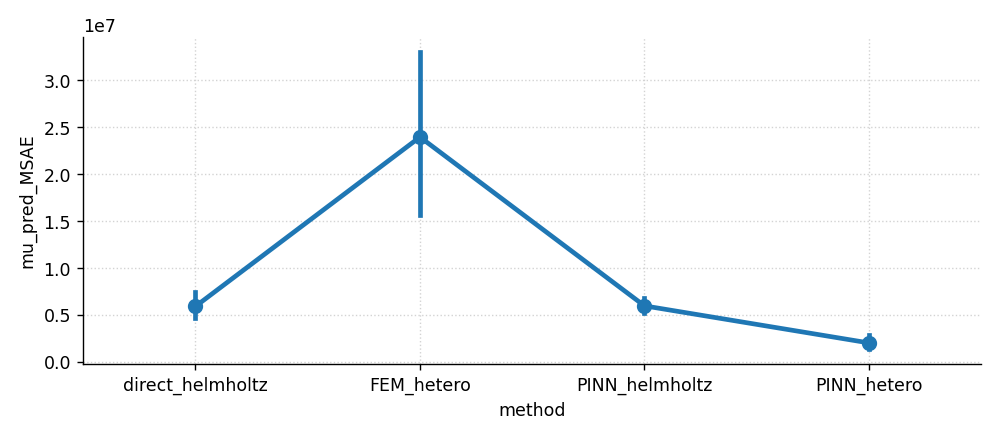

  boot_dist.append(f(*sample, **func_kwargs))



In [38]:
fig = ps.plot(
    mm[mm.spatial_region == 'all'],
    x='method',
    y='mu_pred_MSAE',
    height=3.5,
    width=8,
    legend=False,
    tight=True
)

<IPython.core.display.Javascript object>


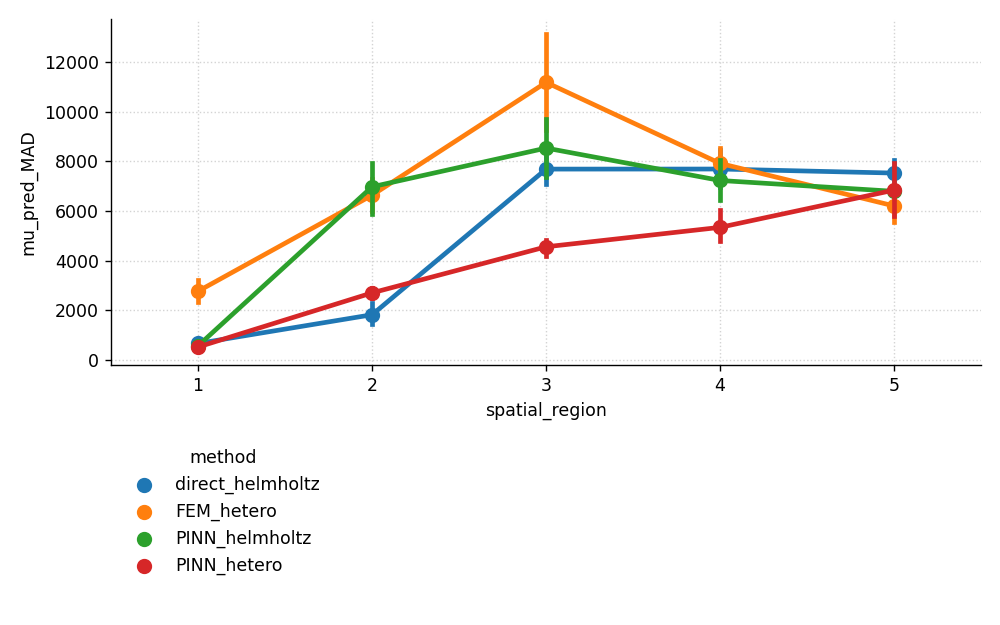

In [35]:
fig = ps.plot(
    mm[(mm.spatial_frequency_bin == 'all') & (mm.spatial_region != 'all')],
    hue='method',
    x='spatial_region',
    y='mu_pred_MAD',
    height=5,
    width=8,
    legend=True,
    tight=True
)